<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Generative adversarial networks


Задание выполнил Лазуков Михаил



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.tensorboard import SummaryWriter


%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/faces_dataset_small.zip -d /content/faces

In [4]:
!rm -r /content/faces/__MACOSX

In [5]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object 
  """
  transforms = tt.Compose([
      tt.Resize(image_size),
      tt.ToTensor(),
      tt.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
  ])
  dataset = ImageFolder('/content/faces', transforms)
  return DataLoader(dataset, batch_size, shuffle=True, num_workers=2)

In [6]:
image_size = 128
batch_size = 32

train_loader = get_dataloader(image_size, batch_size)

In [7]:
def denorm(img_tensors):
    return img_tensors * 0.5 + 0.5

In [26]:
def show_images(images, nmax=64, nrow=8):
    fig, ax = plt.subplots(figsize=(16, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=nrow).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

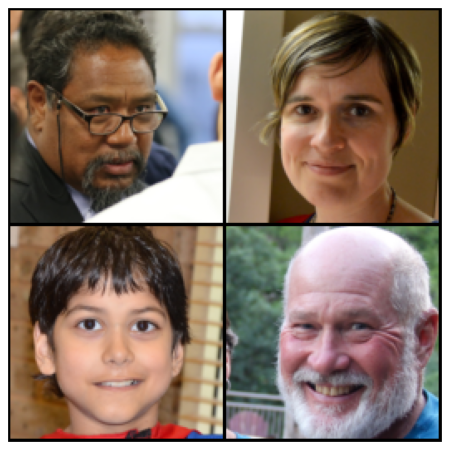

In [9]:
images, _ = next(iter(train_loader))
show_images(images, 4, 2)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [10]:
class ConvBnReLU(nn.Module):
  def __init__(self, in_channels, out_channels, k_size, stride, padding=0, lrelu = False, upsample = False):
    super().__init__()
    self.conv = nn.ConvTranspose2d(in_channels, out_channels, k_size, stride, padding, bias=False) if (upsample) else nn.Conv2d(in_channels, out_channels, k_size, stride, padding, bias=False) 
    self.bn = nn.BatchNorm2d(out_channels)
    self.relu = nn.LeakyReLU(0.2, True) if (lrelu) else nn.ReLU(True)

  def forward(self, x):
    return self.relu(self.bn(self.conv(x)))

In [11]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.convbnlrelu1 = ConvBnReLU(3, 64, 4, 2, 1, True)
    self.convbnlrelu2 = ConvBnReLU(64, 128, 4, 2, 1, True)
    self.convbnlrelu3 = ConvBnReLU(128, 256, 4, 2, 1, True)
    self.convbnlrelu4 = ConvBnReLU(256, 512, 4, 2, 1, True)
    self.convbnlrelu5 = ConvBnReLU(512, 1024, 4, 2, 1, True)
    self.lastconv = nn.Conv2d(1024, 1, 4, 1, 0, bias=False)
    self.flatten = nn.Flatten()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.convbnlrelu1(x)
    x = self.convbnlrelu2(x)
    x = self.convbnlrelu3(x)
    x = self.convbnlrelu4(x)
    x = self.convbnlrelu5(x)
    x = self.lastconv(x)
    x = self.sigmoid(self.flatten(x))
    return x

In [12]:
class Generator(nn.Module):
  def __init__(self, latent):
    super().__init__()
    self.unflatten = nn.Unflatten(1, (latent, 1, 1))
    self.upconv1 = ConvBnReLU(latent, 1024, 4, 1, 0, False, True)
    self.upconv2 = ConvBnReLU(1024, 512, 4, 2, 1, False, True)
    self.upconv3 = ConvBnReLU(512, 256, 4, 2, 1, False, True)
    self.upconv4 = ConvBnReLU(256, 128, 4, 2, 1, False, True)
    self.upconv5 = ConvBnReLU(128, 64, 4, 2, 1, False, True)
    self.lastconv = nn.ConvTranspose2d(64, 3, 4, 2, 1,bias=False)

    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.unflatten(x)
    x = self.upconv1(x)
    x = self.upconv2(x)
    x = self.upconv3(x)
    x = self.upconv4(x)
    x = self.upconv5(x)
    x = self.lastconv(x)
    x = self.tanh(x)
    return x

In [13]:
latent_size = 512 # choose latent size

In [14]:
def weights_init(m):
    classname = m.__class__.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
discriminator = Discriminator().to(device)
generator = Generator(latent_size).to(device)

In [17]:
discriminator.apply(weights_init)

Discriminator(
  (convbnlrelu1): ConvBnReLU(
    (conv): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convbnlrelu2): ConvBnReLU(
    (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convbnlrelu3): ConvBnReLU(
    (conv): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (convbnlrelu4): ConvBnReLU(
    (conv): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.

In [18]:
generator.apply(weights_init)

Generator(
  (unflatten): Unflatten(dim=1, unflattened_size=(512, 1, 1))
  (upconv1): ConvBnReLU(
    (conv): ConvTranspose2d(512, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (upconv2): ConvBnReLU(
    (conv): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (upconv3): ConvBnReLU(
    (conv): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (upconv4): ConvBnReLU(
    (conv): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine

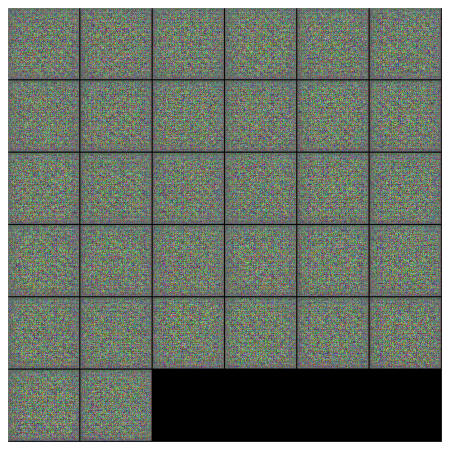

In [19]:
xb = torch.randn(batch_size, latent_size, device=device) 
fake_images = generator(xb)
show_images(fake_images.to('cpu'), 32, 6)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [20]:
def fit_discriminator(discriminator, generator, criterion, optimizer, real_images, device):
  optimizer.zero_grad()
  real_images = real_images.to(device)
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device) - torch.normal(mean=0.0, std=0.05, size = (real_images.size(0), 1), device=device)
  real_loss = criterion(real_preds, real_targets)

  latent = torch.randn(batch_size, latent_size, device=device)
  fake_images = generator(latent)
  fake_preds = discriminator(fake_images)
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device) + torch.normal(mean=0.0, std=0.05, size = (fake_images.size(0), 1), device=device)
  fake_loss = criterion(fake_preds, fake_targets)

  loss = real_loss + fake_loss
  loss.backward()

  optimizer.step()

  return loss.item(), torch.mean(real_preds).item(), torch.mean(fake_preds).item()

In [21]:
def fit_generator(discriminator, generator, criterion, optimizer, device):
  optimizer.zero_grad()
            
  latent = torch.randn(batch_size, latent_size, device=device)
  fake_images = generator(latent)

  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device) - torch.normal(mean=0.0, std=0.05, size = (fake_images.size(0), 1), device=device)

  loss = criterion(preds, targets)

  loss.backward()

  optimizer.step()

  return loss.item()

In [22]:
def fit(model, criterion, optimizer, epochs, train_dl, device, log_dir, tensorboard_enable = True, resume = ""):
    
    start_epoch = 0
    global_step = 0

    if resume != "":
      checkpoint = torch.load(resume)
      model["discriminator"].load_state_dict(checkpoint['discriminator'])
      model["generator"].load_state_dict(checkpoint['generator'])
      start_epoch = checkpoint['epoch']
      global_step = start_epoch * len(train_dl)
      optimizer['discriminator'].load_state_dict(checkpoint['optimizer_discriminator'])
      optimizer['generator'].load_state_dict(checkpoint['optimizer_generator'])
    
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
   

    writer = None
    if tensorboard_enable:
      writer = SummaryWriter(log_dir)

    for epoch in range(start_epoch, epochs): 
        epoch_info = {'loss_g':[], 'loss_d':[], 'real_score':[], 'fake_score':[]}
        for real_images, _ in tqdm(train_dl):
            
            # Train discriminator
            loss_d, cur_real_score, cur_fake_score = fit_discriminator(
                model["discriminator"], model['generator'], 
                criterion["discriminator"], optimizer["discriminator"], 
                real_images, device)
            
            # Train generator
            loss_g = fit_generator(model["discriminator"], model['generator'], 
                criterion["generator"], optimizer["generator"], device)

            epoch_info['loss_g'].append(loss_g)
            epoch_info['loss_d'].append(loss_d)
            epoch_info['real_score'].append(cur_real_score)
            epoch_info['fake_score'].append(cur_fake_score)


            # Write history         
            if global_step % 50 == 0 and writer != None:
              
              latent_v = torch.randn(4, latent_size, device=device)
              images = model["generator"](latent_v)
            
              images = make_grid(denorm(images.to('cpu').detach()), nrow=2)
              
              writer.add_image('Train/Faces', images, global_step)

            global_step += 1
        
        if writer != None:
              writer.add_scalar("Train/Loss_G", sum(epoch_info['loss_g'])/len(epoch_info['loss_g']), global_step)
              writer.add_scalar("Train/Loss_D", sum(epoch_info['loss_d'])/len(epoch_info['loss_d']), global_step)
              writer.add_scalar("Train/Real_score", sum(epoch_info['real_score'])/len(epoch_info['real_score']), global_step)
              writer.add_scalar("Train/Fake_score", sum(epoch_info['fake_score'])/len(epoch_info['fake_score']), global_step)

        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                          epoch+1, epochs, 
                          sum(epoch_info['loss_g'])/len(epoch_info['loss_g']), 
                          sum(epoch_info['loss_d'])/len(epoch_info['loss_d']), 
                          sum(epoch_info['real_score'])/len(epoch_info['real_score']),
                          sum(epoch_info['fake_score'])/len(epoch_info['fake_score'])))
           
        state = {
            'epoch': epoch,
            'global_step': global_step,
            'discriminator': model['discriminator'].state_dict(),
            'generator': model['generator'].state_dict(),
            'optimizer_discriminator': optimizer['discriminator'].state_dict(),
            'optimizer_generator': optimizer['generator'].state_dict()
        }
        torch.save(state, "/content/drive/MyDrive/log_dcgan/dcgan.pth")


In [23]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

optimizer = {
    "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                      lr=0.0002, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(model["generator"].parameters(),
                                  lr=0.0002, betas=(0.5, 0.999))
}


criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

epochs = 250

In [ ]:
fit(model, criterion, optimizer, epochs, train_loader, device, "/content/drive/MyDrive/log_dcgan/", True, '/content/drive/MyDrive/log_dcgan/dcgan.pth')

In [50]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir '/content/drive/MyDrive/log_dcgan/'

Отдельно скачал данные по обучению из Tensorboard, чтобы разместить потери дискриминатор и генератора на одном графике, а также score для реальный и сгенерированных изображений

In [54]:
import pandas as pd
losses_g = pd.read_csv('/content/Train_Loss_G.csv')
losses_d = pd.read_csv('/content/Train_Loss_D.csv')
real_scores = pd.read_csv('/content/Train_Real_score.csv')
fake_scores = pd.read_csv('/content/Train_Fake_score.csv')

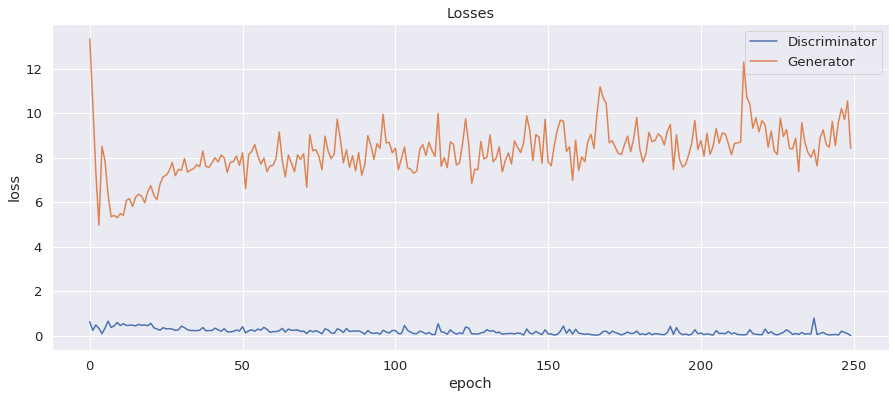

In [57]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d['Value'], '-')
plt.plot(losses_g['Value'], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

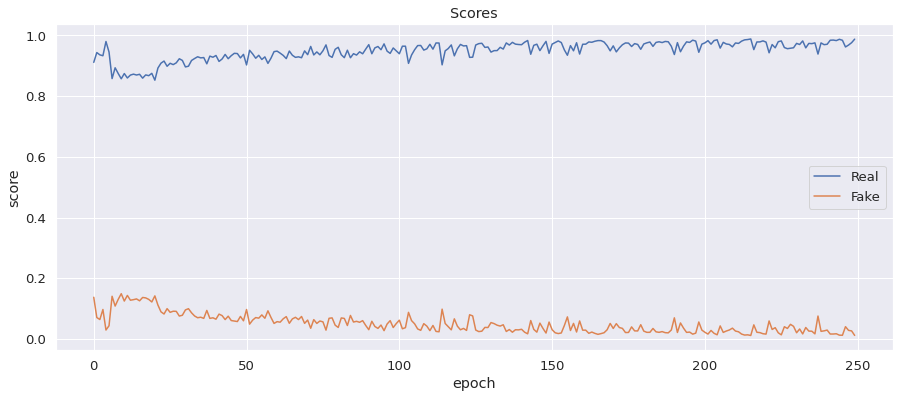

In [59]:
plt.figure(figsize=(15, 6))

plt.plot(real_scores['Value'], '-')
plt.plot(fake_scores['Value'], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

За первые 10-20 эпох значения потерь на генераторе и дискриминатор стабилизируется. Дискриминатор начинает с большей вероятностью отличать сгенерированные изображения от реальных. 
В ходе попыток по подбору гиперпараметров уже за первые 20 эпох становится понятно вероятность дальнейшего успеха, т.к. если они подобраны неверно, то либо дискриминатор задавит генератор, либо генератор научится обманывать дискриминатор. При это подобное может происходить и уже на более поздних стадиях обучения, но вероятность подобного значительно ниже.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

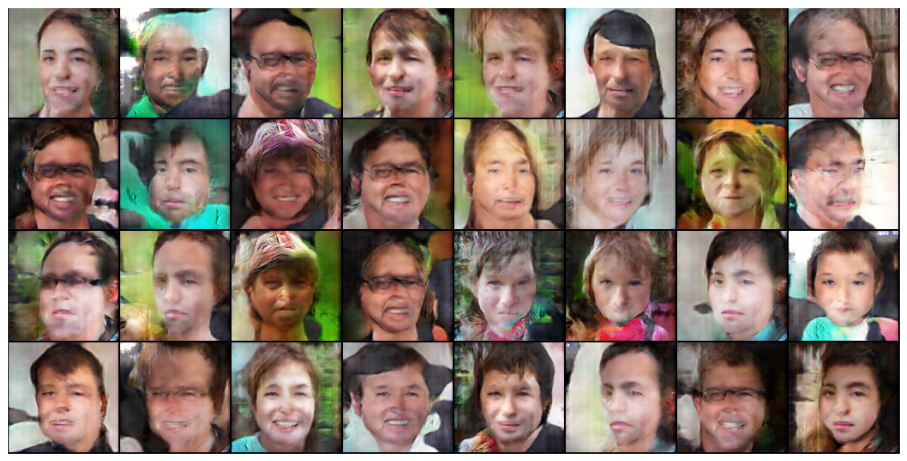

In [66]:
xb = torch.randn(batch_size, latent_size, device=device) 
fake_images = model['generator'](xb)
show_images(fake_images.to('cpu'))

Как вам качество получившихся изображений?

Качество изображений определенно не дотягиевает до примеров из обучающей выборки, но все же я считаю это приемлемым. Примутствует довольно большое разнообразие лиц, основные составляющие лица присутствуют на большинстве изображений, в некоторых местах есть попытки даже отрисовать волосы более естественными. В целом, вероятнее всего можно добиться лучших результатов используя другие функции потерь.

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [83]:
import torchvision
import torch
from torch import nn

class MobileNetV3(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        net = torchvision.models.mobilenet_v3_large(pretrained=pretrained)
        features = net.features
        self.layer1 = nn.Sequential(*features[0:16])
        self.avg = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, x):
        x = self.layer1(x)
        x = self.avg(x)       
        return x

In [84]:
feature_extractor = MobileNetV3().to(device)

In [86]:
fake_images = []
real_images = []

In [87]:
for batch in train_loader:
  images, _ = batch
  
  real_features = feature_extractor(images.to(device))
  real_images.append(real_features.to('cpu').detach())
  
  latent = torch.randn(len(images), latent_size, device=device) 
  fake = model['generator'](latent)
  
  fake_features = feature_extractor(fake)
  fake_images.append(fake_features.to('cpu').detach())

In [88]:
fakeimages = torch.cat(fake_images, dim=0)
realimages = torch.cat(real_images, dim=0)

In [89]:
fakeimages = fakeimages.view(len(fakeimages), -1)
realimages = realimages.view(len(realimages), -1)

In [90]:
fake_targets = torch.zeros(len(fakeimages), 1)
real_targets = torch.ones(len(realimages), 1)

In [91]:
X = torch.cat([fakeimages, realimages], dim = 0).numpy()
y = torch.cat([fake_targets, real_targets], dim = 0).view(-1).numpy()

In [92]:
from sklearn.model_selection import LeaveOneOut


In [93]:
loo = LeaveOneOut()

In [94]:
loo.get_n_splits(X)

6286

In [95]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
global_score = []
for train_index, test_index in tqdm(loo.split(X)):
  knn = KNeighborsClassifier(1)
  knn.fit(X[train_index],y[train_index])
  global_score.append(knn.score(X[test_index], y[test_index]))

In [98]:
np.array(global_score).mean()

0.720489977728285

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Идеальная точность равняется 0.5. Это значит, что признаки, которые выделяет нейросеть для классификиции распределены довольно равномерно между сгенерированными и реальными изображениями, следовательно генератор выделил верные признаки с реальных изображений. Результат нельзя довольно объективно оценить, т.к. он может меняться от выбора сети для извлечения признаков, а также в зависимости от размера изображения показатель тоже значительно меняется. До этого, на обученной сети, генерирующей изображения 64х64 значение было порядка 0.6, хотя на глаз качество генерации было хуже.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [99]:
from sklearn.manifold import TSNE

In [100]:
x = TSNE(n_components=2).fit_transform(X)

In [101]:
vector = [[], []]
vector[0].append(x[0:len(fakeimages)])
vector[1].append(x[len(fakeimages):])

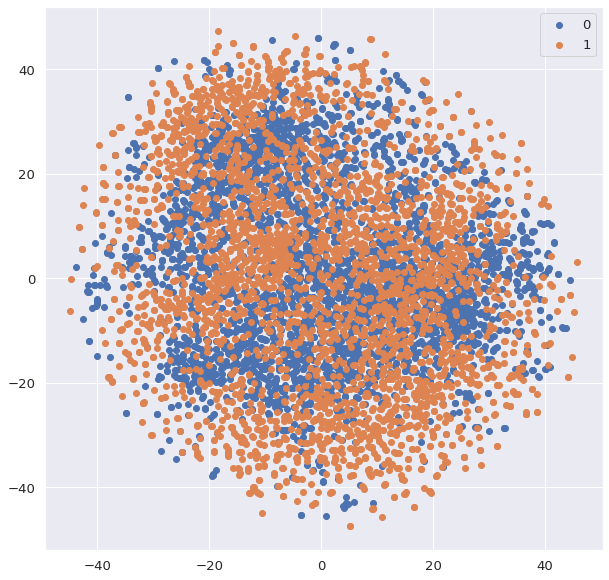

In [102]:
fig, ax = plt.subplots()

for i, a in enumerate(vector):
  a = np.array(a[0])
  ax.scatter(a[:,0], a[:, 1], label='%d' % (i))
fig.set_figwidth(10)    #  ширина и
fig.set_figheight(10)    #  высота "Figure"
plt.legend()
plt.show()
#0 - сгенерированные, 1 - реальные

Прокомментируйте получившийся результат:

В целом результат подтверждает цифру, полученную в предыдущем пункте. Хоть и признаки сгерированных и реальных изображений распределены примерно на одной области, но всеже можно видеть, как они довольно сильно сгуппированы между собой. Присутствуют область где кучно расположены как реальные изображения, так и сгенерированные.